In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

class MyDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Augmentation
IMAGE_DIR = '/Mineral/CPX seg'
TRAIN_SPLIT_FILE = '/Mineral/train_split.csv'
VAL_SPLIT_FILE = '/Mineral/val_split.csv'
train_data = pd.read_csv(TRAIN_SPLIT_FILE)
val_data = pd.read_csv(VAL_SPLIT_FILE)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MyDataset(train_data, IMAGE_DIR, transform)
val_dataset = MyDataset(val_data, IMAGE_DIR, transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# class weight
labels = train_data['Class'].values
classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

class LeNet5(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train, correct_train, running_loss_train = 0, 0, 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss_train / total_train
        train_accuracy = correct_train / total_train * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        model.eval()
        total_val, correct_val, running_loss_val = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss_val / total_val
        val_accuracy = correct_val / total_val * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200)


Epoch 1/200, Train Loss: 1.1023, Train Accuracy: 43.62%
Validation Loss: 1.0995, Validation Accuracy: 11.99%
Epoch 2/200, Train Loss: 1.0950, Train Accuracy: 50.51%
Validation Loss: 1.0956, Validation Accuracy: 32.53%
Epoch 3/200, Train Loss: 1.0800, Train Accuracy: 63.27%
Validation Loss: 1.0385, Validation Accuracy: 59.25%
Epoch 4/200, Train Loss: 0.9661, Train Accuracy: 42.60%
Validation Loss: 0.9089, Validation Accuracy: 36.30%
Epoch 5/200, Train Loss: 0.8056, Train Accuracy: 53.01%
Validation Loss: 0.7973, Validation Accuracy: 38.01%
Epoch 6/200, Train Loss: 0.7161, Train Accuracy: 61.22%
Validation Loss: 0.7800, Validation Accuracy: 60.62%
Epoch 7/200, Train Loss: 0.7073, Train Accuracy: 58.50%
Validation Loss: 0.7709, Validation Accuracy: 81.16%
Epoch 8/200, Train Loss: 0.7076, Train Accuracy: 71.41%
Validation Loss: 0.8509, Validation Accuracy: 66.10%
Epoch 9/200, Train Loss: 0.6825, Train Accuracy: 72.29%
Validation Loss: 0.8376, Validation Accuracy: 75.68%
Epoch 10/200, Train

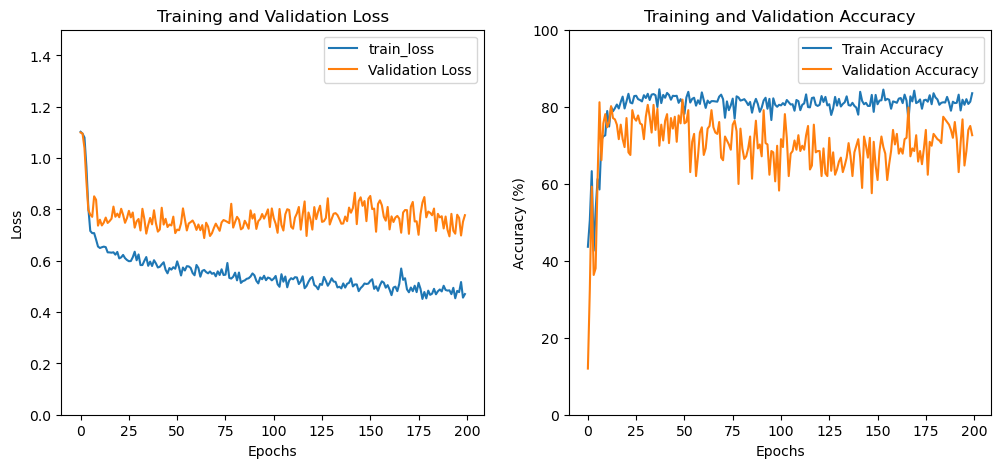

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 100)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.legend()

plt.show()


### **TEST SET Model Evaluation**

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from scipy.stats import bootstrap
import torch.nn as nn
import torch.optim as optim

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label



IMAGE_DIR = '/Mineral/CPX seg'
TEST_SPLIT_FILE = '/Mineral/test_split.csv'

test_data = pd.read_csv(TEST_SPLIT_FILE)

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_dataset = MyDataset(test_data, IMAGE_DIR, transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = torch.load('/Mineral/le-1.path')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    all_probs = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probabilities = torch.softmax(outputs, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_losses = np.array(all_losses)
    return all_probs, all_labels, all_losses

def bootstrap_metric(y_true, y_prob, metric_func, n_bootstrap=1000, alpha=0.05, **kwargs):
    rng = np.random.default_rng()
    indices = np.arange(len(y_true))
    bootstrapped_scores = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        if metric_func == roc_auc_score:
            score = metric_func(y_true[sample_indices], y_prob[sample_indices], **kwargs)
        else:
            y_pred = np.argmax(y_prob[sample_indices], axis=1)
            score = metric_func(y_true[sample_indices], y_pred, **kwargs)
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    ci_lower = sorted_scores[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_scores[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def bootstrap_loss(losses, n_bootstrap=1000, alpha=0.05): #resample rate 1000
    rng = np.random.default_rng()
    indices = np.arange(len(losses))
    bootstrapped_losses = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        sample_loss = losses[sample_indices]
        bootstrapped_losses.append(np.mean(sample_loss))
    sorted_losses = np.sort(bootstrapped_losses)
    ci_lower = sorted_losses[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_losses[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_losses), ci_lower, ci_upper


test_probs, test_labels, test_losses = evaluate_model(model, test_loader, criterion, device)

# 95% CI
class_labels = np.unique(test_labels)
metrics = {}
for class_label in class_labels:
    auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels == class_label, test_probs[:, class_label], roc_auc_score)
    balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: balanced_accuracy_score(y_true == class_label, y_pred == class_label))
    sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true == class_label, y_pred == class_label))
    specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true == class_label, y_pred == class_label))

    metrics[class_label] = {
        "AUC-ROC": (auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high),
        "Balanced Accuracy": (balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high),
        "Sensitivity": (sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high),
        "Specificity": (specificity_mean, specificity_ci_low, specificity_ci_high)
    }


print("Class\t\tAUC-ROC\t\t\tBalanced Accuracy\tSensitivity\t\tSpecificity")
for class_label, metric_values in metrics.items():
    auc_roc = metric_values["AUC-ROC"]
    balanced_acc = metric_values["Balanced Accuracy"]
    sensitivity = metric_values["Sensitivity"]
    specificity = metric_values["Specificity"]
    print(f"{class_label}\t\t{auc_roc[0]:.2f} ({auc_roc[1]:.2f}-{auc_roc[2]:.2f})\t"
          f"{balanced_acc[0]:.2f} ({balanced_acc[1]:.2f}-{balanced_acc[2]:.2f})\t"
          f"{sensitivity[0]:.2f} ({sensitivity[1]:.2f}-{sensitivity[2]:.2f})\t"
          f"{specificity[0]:.2f} ({specificity[1]:.2f}-{specificity[2]:.2f})")


auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels, test_probs, roc_auc_score, multi_class='ovr')
balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, balanced_accuracy_score)
sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'))
specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'))


loss_mean, loss_ci_low, loss_ci_high = bootstrap_loss(test_losses)

print(f"Overall\t\t{auc_roc_mean:.2f} ({auc_roc_ci_low:.2f}-{auc_roc_ci_high:.2f})\t"
      f"{balanced_acc_mean:.2f} ({balanced_acc_ci_low:.2f}-{balanced_acc_ci_high:.2f})\t"
      f"{sensitivity_mean:.2f} ({sensitivity_ci_low:.2f}-{sensitivity_ci_high:.2f})\t"
      f"{specificity_mean:.2f} ({specificity_ci_low:.2f}-{specificity_ci_high:.2f})")
print(f"Loss\t\t{loss_mean:.4f} ({loss_ci_low:.4f}-{loss_ci_high:.4f})")

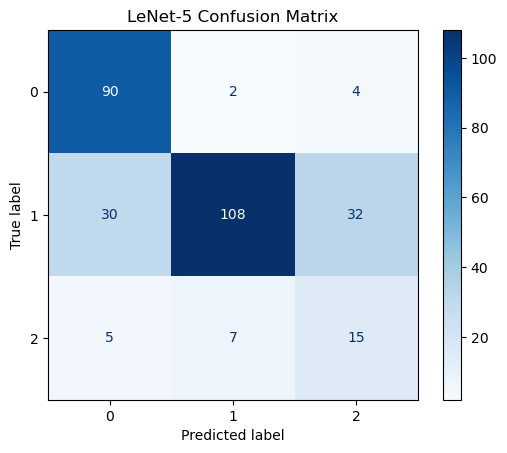

              precision    recall  f1-score   support

           0       0.72      0.94      0.81        96
           1       0.92      0.64      0.75       170
           2       0.29      0.56      0.38        27

    accuracy                           0.73       293
   macro avg       0.65      0.71      0.65       293
weighted avg       0.80      0.73      0.74       293



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


test_preds, test_trues = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(test_trues, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['0', '1', '2'])
disp.plot(cmap='Blues')
plt.title('LeNet-5 Confusion Matrix')
plt.show()


report = classification_report(test_trues, test_preds, target_names=['0', '1', '2'])
print(report)


In [ ]:
def get_predictions(model, data_loader, device):

    all_probs = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_probs)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_histograms(probs, num_classes):
    plt.figure(figsize=(6, 4))


    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 0.8, num_classes)]

    for i in range(num_classes):
        plt.hist(probs[:, i], bins=30, alpha=0.5, label=f'Class {i}', color=colors[i])

    plt.title('LeNet-5 Prediction Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


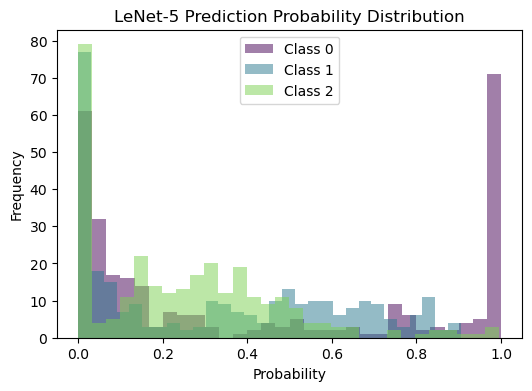

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_probs = get_predictions(model, test_loader, device)
num_classes = 3
plot_prediction_histograms(test_probs, num_classes)


In [ ]:
def evaluate_model(model, data_loader, device):
    test_probs = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_probs = np.array(test_probs)
    test_labels = np.array(test_labels)
    return test_probs, test_labels


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(all_labels, all_probs, num_classes):
    plt.figure(figsize=(6, 4))

    for class_index in range(num_classes):
        fpr, tpr, thresholds = roc_curve(all_labels == class_index, all_probs[:, class_index])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'Class {class_index} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LeNet-5')
    plt.legend(loc="lower right")
    plt.show()


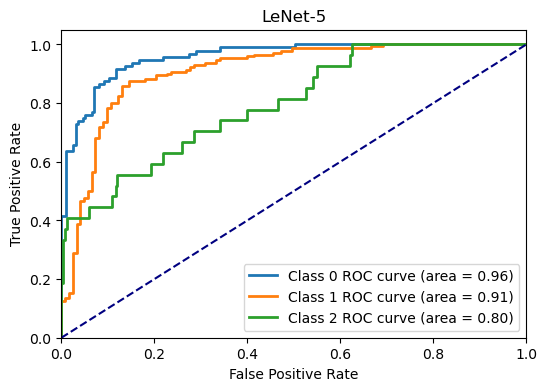

In [ ]:
test_probs, test_labels = evaluate_model(model, test_loader, device)
num_classes = len(np.unique(test_labels))
plot_roc_curves(test_labels, test_probs, num_classes)